# Non-Linear Modeling

<a target="_blank" href="https://colab.research.google.com/github/intro-stat-learning/ISLP_labs/blob/v2.2/Ch07-nonlin-lab.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/intro-stat-learning/ISLP_labs/v2.2?labpath=Ch07-nonlin-lab.ipynb)

In this lab, we demonstrate some of the nonlinear models discussed in
this chapter. We use the `Wage`  data as a running example, and show that many of the complex non-linear fitting procedures discussed can easily be implemented in `Python`.

As usual, we start with some of our standard imports.

In [2]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=53b8b9c45c223ba3f558b90ba605524c51844eee66e6c0590a4037cb9e054817
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [3]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
              poly,
              ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

We again collect the new imports
needed for this lab. Many of these are developed specifically for the
`ISLP` package.

In [5]:
from pygam import (s as s_gam,
           l as l_gam,
           f as f_gam,
           LinearGAM,
           LogisticGAM)

from ISLP.transforms import (BSpline,
                NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
             degrees_of_freedom,
             plot as plot_gam,
             anova as anova_gam)


## Polynomial Regression and Step Functions
We start by demonstrating how Figure~\ref{Ch7:fig:poly} can be reproduced.
Let's  begin by loading the data.

In [55]:
Data = load_data('Boston')
Data.describe()
y = Data['nox']
dis = Data['dis']


In [14]:
# 下面需不需要 raw=True？
poly_dis = MS([poly('dis', degree=3, raw=True)]).fit(Data)
M = sm.OLS(y, poly_dis.transform(Data)).fit()
summarize(M)


,coef,std err,t,P>|t|
intercept,0.9341,0.021,45.110,0.0
"poly(dis, degree=3, raw=True)[0]",-0.1821,0.015,-12.389,0.0
"poly(dis, degree=3, raw=True)[1]",0.0219,0.003,7.476,0.0
"poly(dis, degree=3, raw=True)[2]",-0.0009,0.000,-5.124,0.0


We now create a grid of values for `age` at which we want
predictions.

In [54]:
dis_grid = np.linspace(dis.min(),
             dis.max(),
             100)
dis_df = pd.DataFrame({'dis': dis_grid})


In [18]:
def plot_nox_fit(dis_df,
         basis,
         title):

    X = basis.transform(Data)
    Xnew = basis.transform(dis_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,
          y,
          facecolor='gray',
          alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Dis', fontsize=20)
    ax.set_ylabel('Nox', fontsize=20);
    return ax


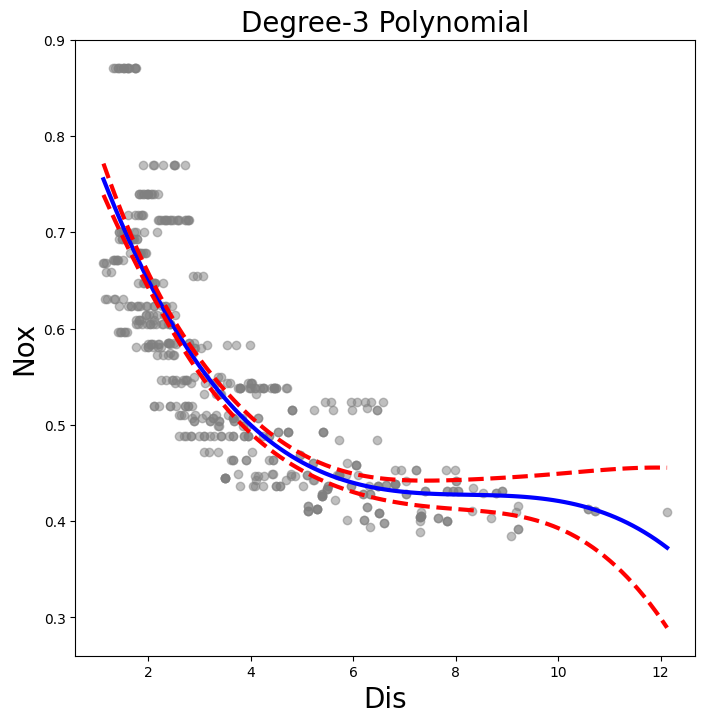

In [19]:
plot_nox_fit(dis_df,
       poly_dis,
       'Degree-3 Polynomial');


In [52]:
def get_RSS(dis_df, basis, d):
  X = basis.transform(Data)
  Xnew = basis.transform(dis_df)
  M = sm.OLS(y, X).fit()
  y_fitted = M.fittedvalues
  residuals = y - y_fitted
  rss = np.sum(residuals ** 2)
  print("Residual Sum of Squares of Degree-{d} Polynomial: {rss}".format(d=d,rss=rss))
  return rss


Residual Sum of Squares of Degree-1 Polynomial: 2.7685628589692755
Residual Sum of Squares of Degree-2 Polynomial: 2.0352618689352564
Residual Sum of Squares of Degree-3 Polynomial: 1.9341067071790703
Residual Sum of Squares of Degree-4 Polynomial: 1.9329813272985947
Residual Sum of Squares of Degree-5 Polynomial: 1.9152899610843044
Residual Sum of Squares of Degree-6 Polynomial: 1.878257298508164
Residual Sum of Squares of Degree-7 Polynomial: 1.8494836145829787
Residual Sum of Squares of Degree-8 Polynomial: 1.8356296890676882
Residual Sum of Squares of Degree-9 Polynomial: 1.8333308044915937
Residual Sum of Squares of Degree-10 Polynomial: 1.8321711239313427


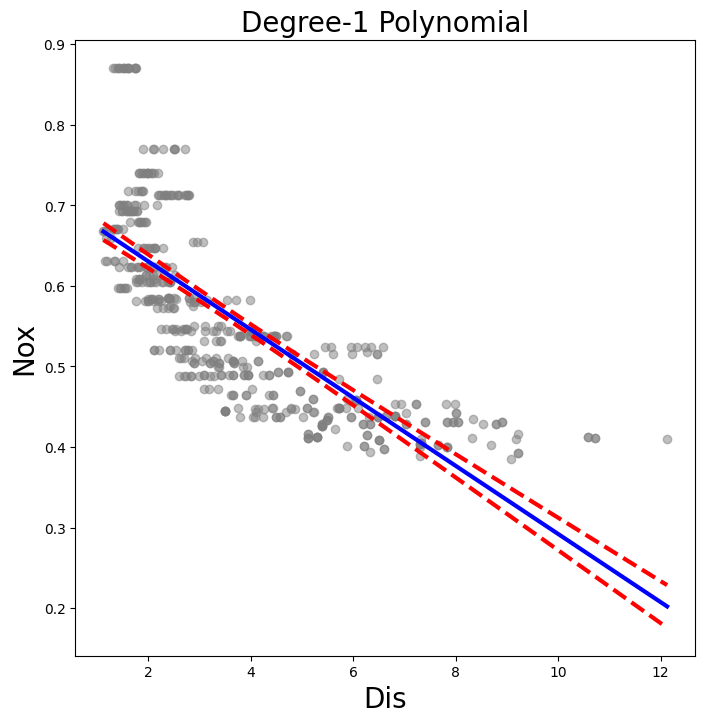

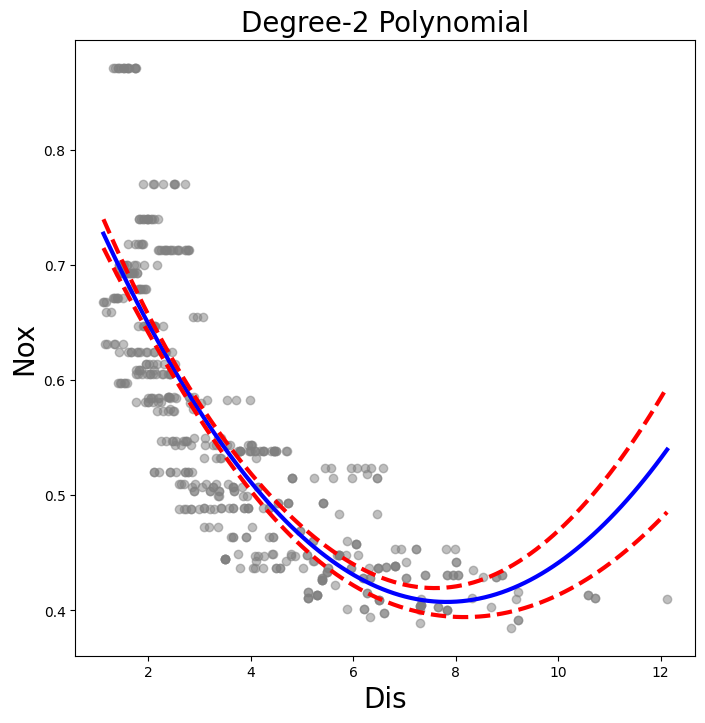

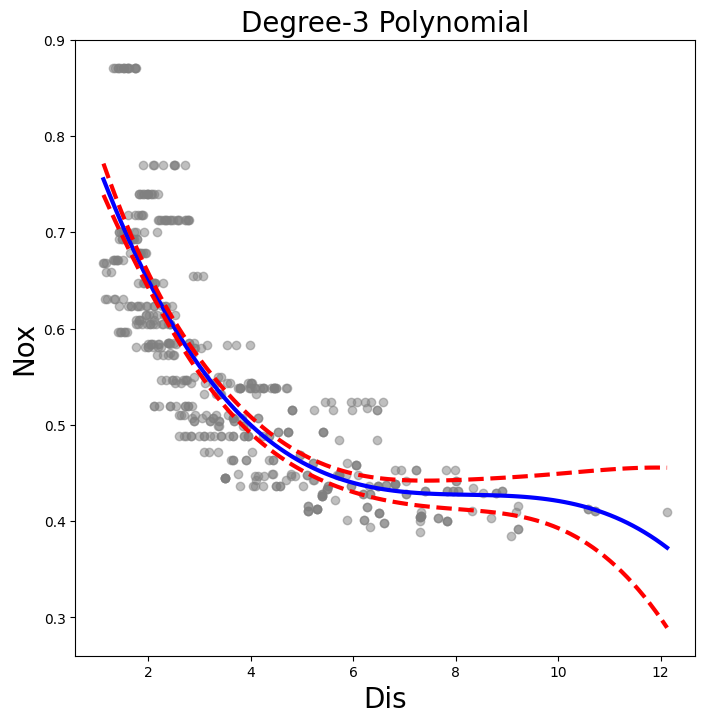

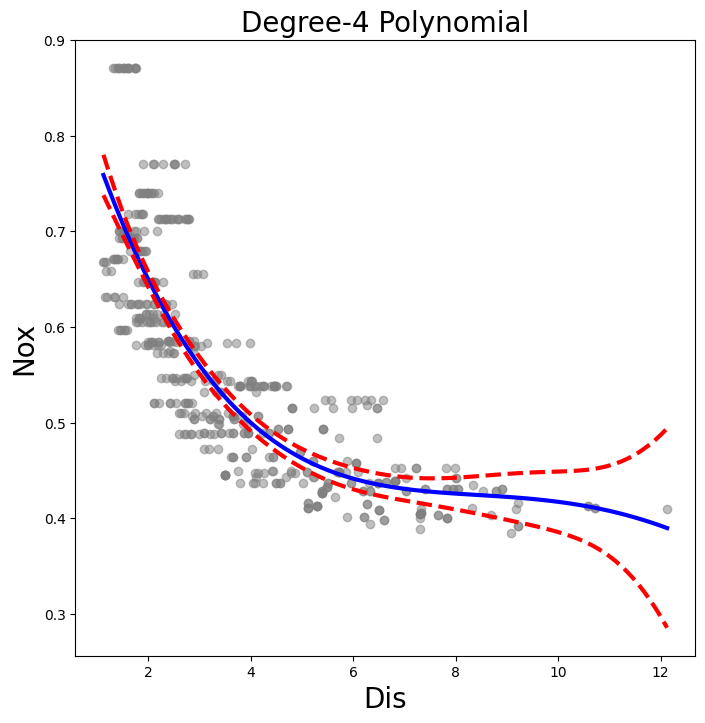

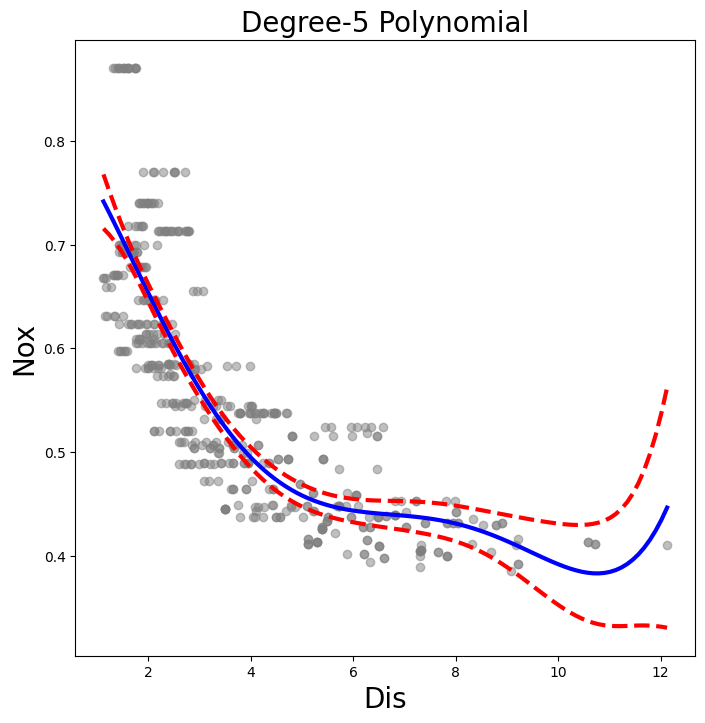

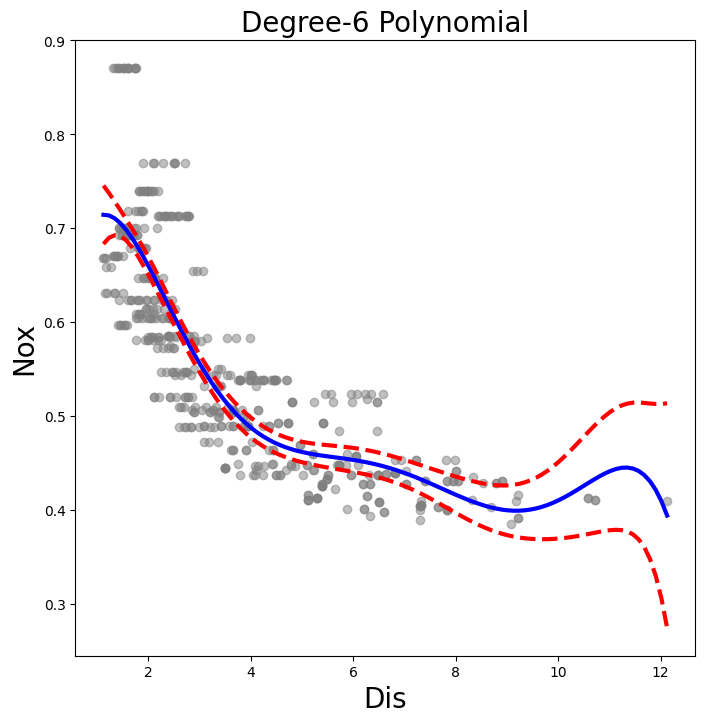

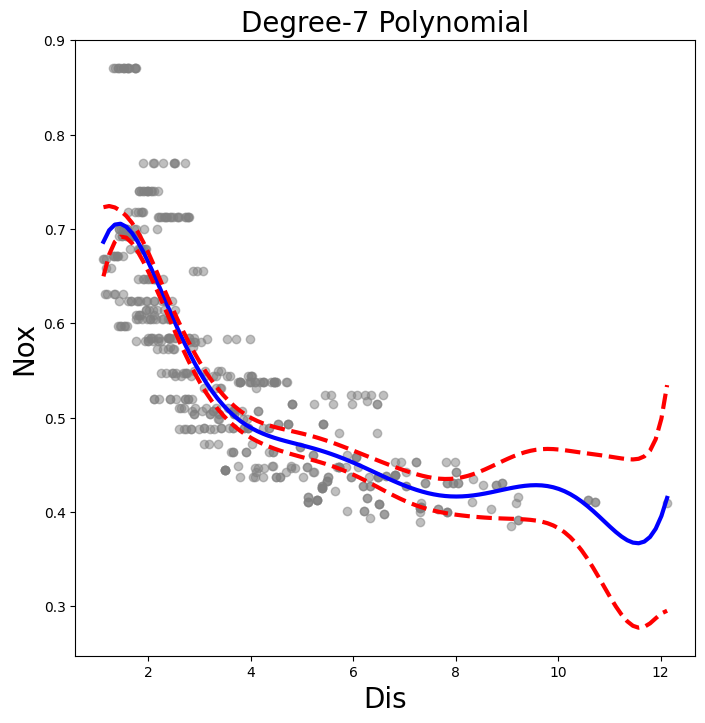

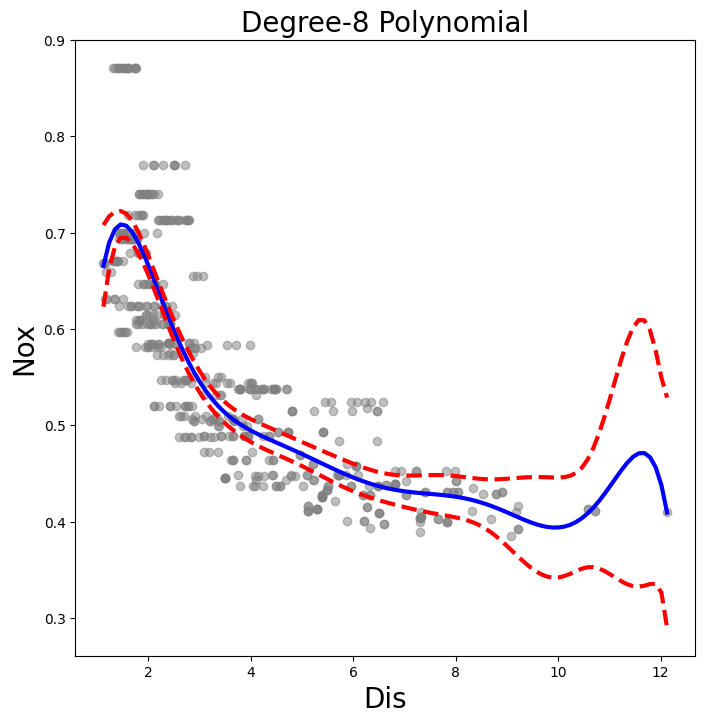

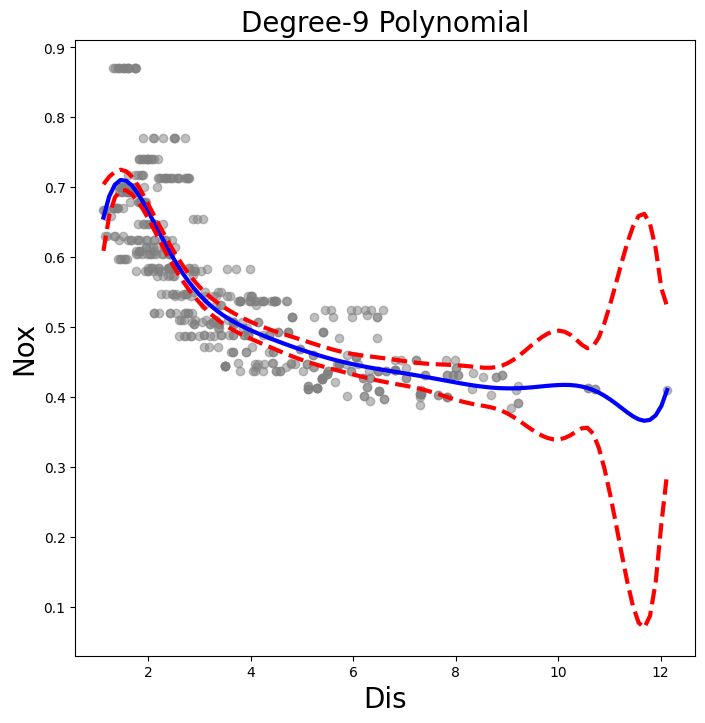

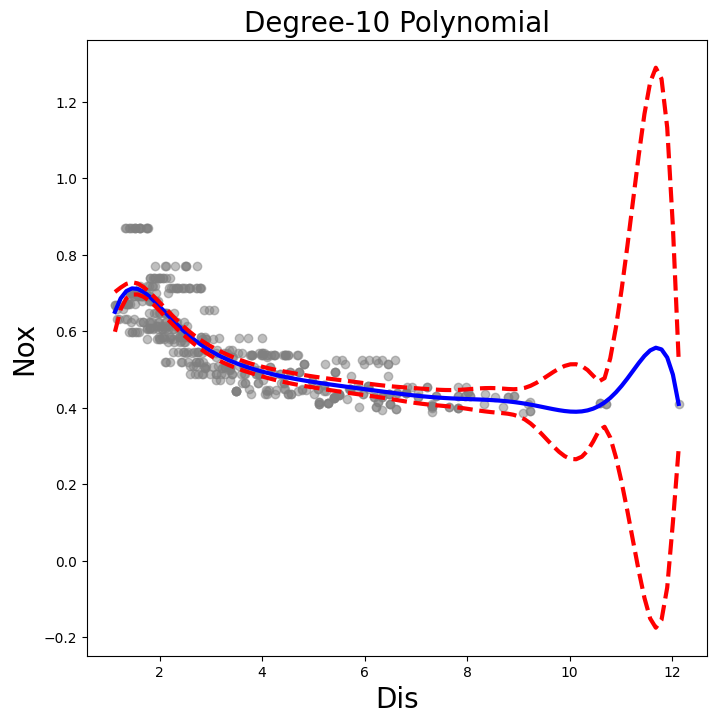

In [57]:
for d in range(1, 11):
  model = MS([poly('dis', degree=d)])
  X = model.fit(Data)
  plot_nox_fit(dis_df, X, 'Degree-{} Polynomial'.format(d))
  get_RSS(dis_df, X ,d)



Optimal polynomial degree: 2


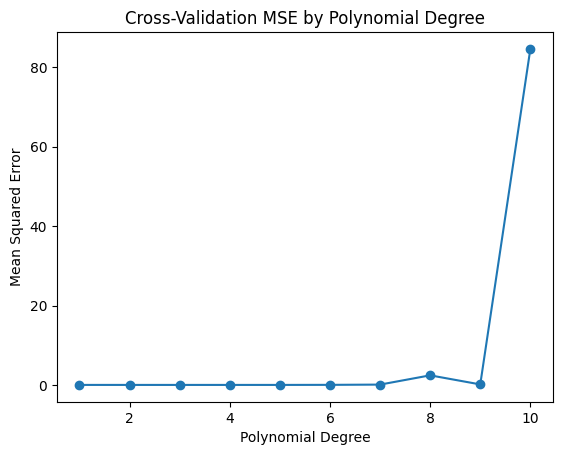

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np

# Example data
X = Data[['dis']]  # Independent variable(s)
y = Data['nox']      # Dependent variable

# Store cross-validation scores
degrees = range(1, 11)
cv_scores = []

# Loop through degrees
for d in degrees:
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores))  # Take the mean of negative MSE

# Select optimal degree
optimal_degree = degrees[np.argmin(cv_scores)]
print(f"Optimal polynomial degree: {optimal_degree}")

# Plot the validation errors
import matplotlib.pyplot as plt
plt.plot(degrees, cv_scores, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation MSE by Polynomial Degree')
plt.show()


## Splines
In order to fit regression splines, we use transforms
from the `ISLP` package. The actual spline
evaluation functions are in the `scipy.interpolate` package;
we have simply wrapped them as transforms
similar to `Poly()` and `PCA()`.

In Section~\ref{Ch7:sec:scolr-splin}, we saw
that regression splines can be fit by constructing an appropriate
matrix of basis functions.  The `BSpline()`  function generates the
entire matrix of basis functions for splines with the specified set of
knots. By default, the B-splines produced are cubic. To change the degree, use
the argument `degree`.

In [59]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(dis)
bs_age = bs_.transform(dis)
bs_age.shape


ValueError: internal_knots should be less than our equal to upper_bound

This results in a seven-column matrix, which is what is expected for a cubic-spline basis with 3 interior knots.
We can form this same matrix using the `bs()` object,
which facilitates adding this to a model-matrix builder (as in `poly()` versus its workhorse `Poly()`) described in Section~\ref{Ch7-nonlin-lab:polynomial-regression-and-step-functions}.

We now fit a cubic spline model to the `Wage`  data.

In [ ]:
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)


,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


The column names are a little cumbersome, and have caused us to truncate the printed summary. They can be set on construction using the `name` argument as follows.

In [ ]:
bs_age = MS([bs('age',
                internal_knots=[25,40,60],
                name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)


,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is because, by default,
`bs()` assumes `intercept=False`, since we typically have an overall intercept in the model.
So it generates the spline basis with the given knots,  and then discards one of the basis functions to account for the intercept.

We could also use the `df` (degrees of freedom) option to
specify the complexity of the spline.  We see above that with 3 knots,
the spline basis has 6 columns or degrees of freedom.  When we specify
`df=6` rather than the actual knots, `bs()` will produce a
spline with 3 knots chosen at uniform quantiles of the training data.
We can see these chosen knots most easily using `Bspline()` directly:

In [ ]:
BSpline(df=6).fit(age).internal_knots_


array([33.75, 42.  , 51.  ])

 When asking for six degrees of freedom,
the transform chooses knots at ages 33.75, 42.0, and 51.0,
which correspond to the 25th, 50th, and 75th percentiles of
`age`.

When using B-splines we need not limit ourselves to cubic polynomials
(i.e. `degree=3`). For instance, using `degree=0` results
in piecewise constant functions, as in our example with
`pd.qcut()` above.


In [ ]:
bs_age0 = MS([bs('age',
                 df=3,
                 degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())


,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


This fit should be compared with cell [15] where we use `qcut()`
to create four bins by cutting at the 25%, 50% and 75% quantiles of
`age`.  Since we specified `df=3` for degree-zero splines here, there will also be
knots at the same three quantiles. Although the coefficients appear different, we
see that this is a result of the different coding. For example, the
first coefficient is identical in both cases, and is the mean response
in the first bin. For the second coefficient, we have
$94.158 + 22.349 = 116.507 \approx 116.611$, the latter being the mean
in the second bin in cell [15]. Here the intercept is coded by a column
of ones, so the second, third and fourth coefficients are increments
for those bins. Why is the sum not exactly the same? It turns out that
the `qcut()` uses $\leq$, while `bs()` uses $<$ when
deciding bin membership.


    




    


In order to fit a natural spline, we use the `NaturalSpline()`
transform with the corresponding helper `ns()`.  Here we fit a natural spline with five
degrees of freedom (excluding the intercept) and plot the results.

In [ ]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


We now plot the natural spline using our plotting function.

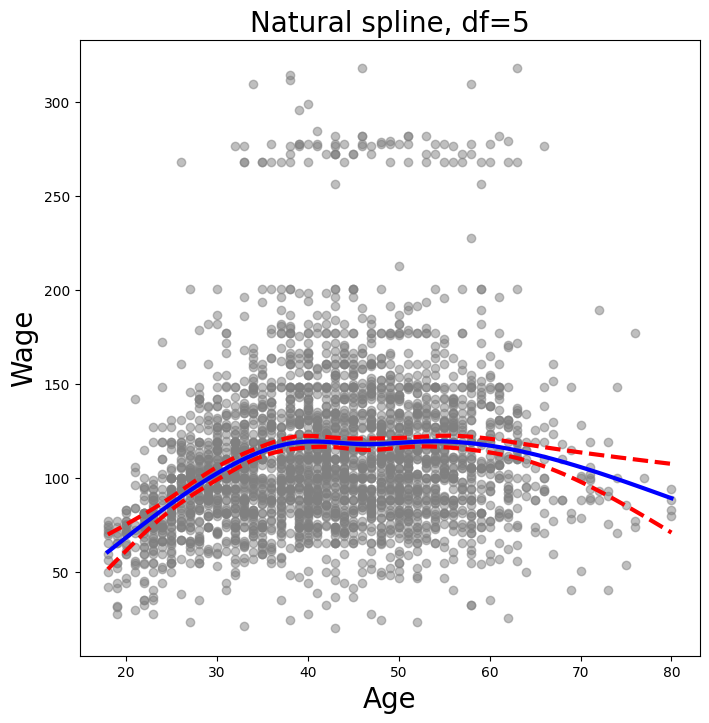

In [ ]:
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5');


## Smoothing Splines and GAMs
A smoothing spline is a special case of a GAM with squared-error loss
and a single feature. To fit GAMs in `Python` we will use the
`pygam` package which can be installed via `pip install pygam`. The
estimator `LinearGAM()` uses squared-error loss.
The GAM is specified by associating each column
of a model matrix with a particular smoothing operation:
`s` for smoothing spline; `l` for linear, and `f` for factor or categorical variables.
The argument `0` passed to `s` below indicates that this smoother will
apply to the first column of a feature matrix. Below, we pass it a
matrix with a single column: `X_age`. The argument `lam` is the penalty parameter $\lambda$ as discussed in Section~\ref{Ch7:sec5.2}.

In [ ]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

The `pygam` library generally expects a matrix of features so we reshape `age` to be a matrix (a two-dimensional array) instead
of a vector (i.e. a one-dimensional array). The `-1` in the call to the `reshape()` method tells `numpy` to impute the
size of that dimension based on the remaining entries of the shape tuple.

Let’s investigate how the fit changes with the smoothing parameter `lam`.
The function `np.logspace()` is similar to `np.linspace()` but spaces points
evenly on the log-scale. Below we vary `lam` from $10^{-2}$ to $10^6$.

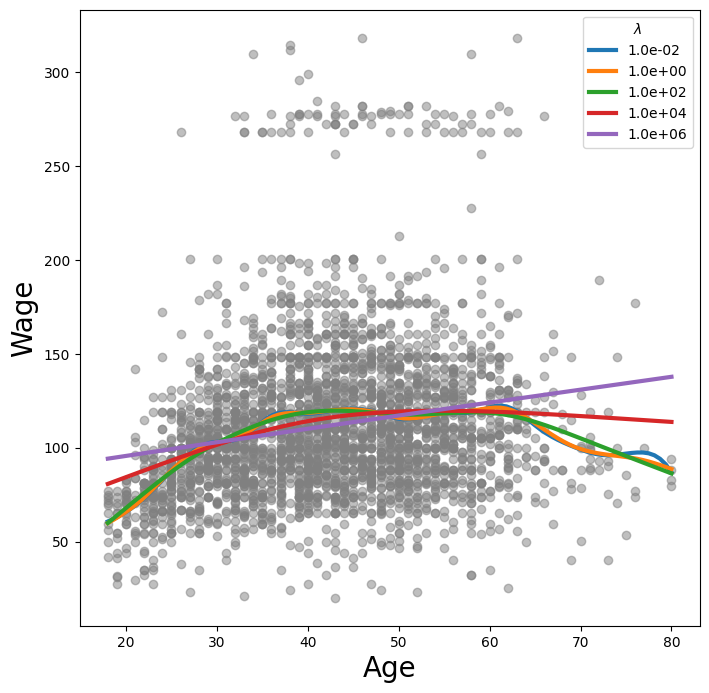

In [ ]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');


The `pygam` package can perform a search for an optimal smoothing parameter.

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

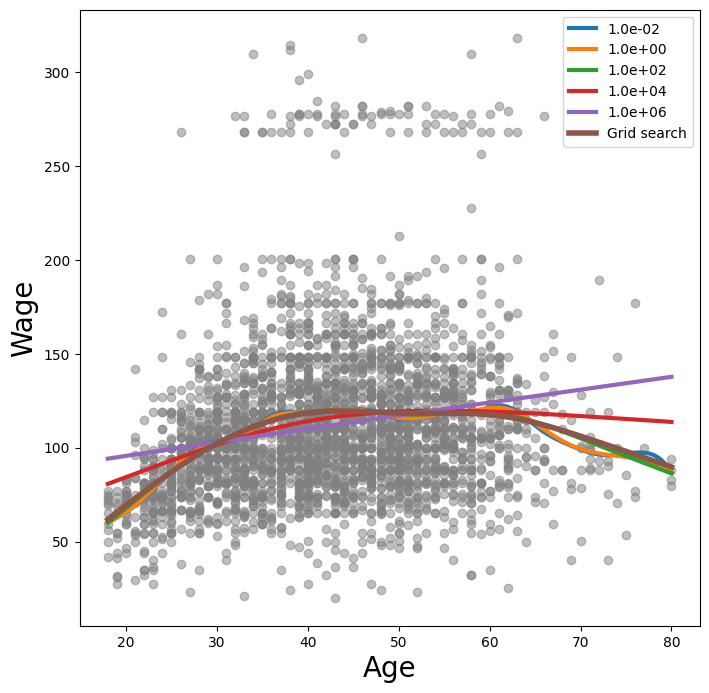

In [ ]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig


Alternatively, we can fix the degrees of freedom of the smoothing
spline using a function included in the `ISLP.pygam` package. Below we
find a value of $\lambda$ that gives us roughly four degrees of
freedom. We note here that these degrees of freedom include the
unpenalized intercept and linear term of the smoothing spline, hence there are at least two
degrees of freedom.

In [ ]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)


4.000000100001664

Let’s vary the degrees of freedom in a similar plot to above. We choose the degrees of freedom
as the desired degrees of freedom plus one to account for the fact that these smoothing
splines always have an intercept term. Hence, a value of one for `df` is just a linear fit.

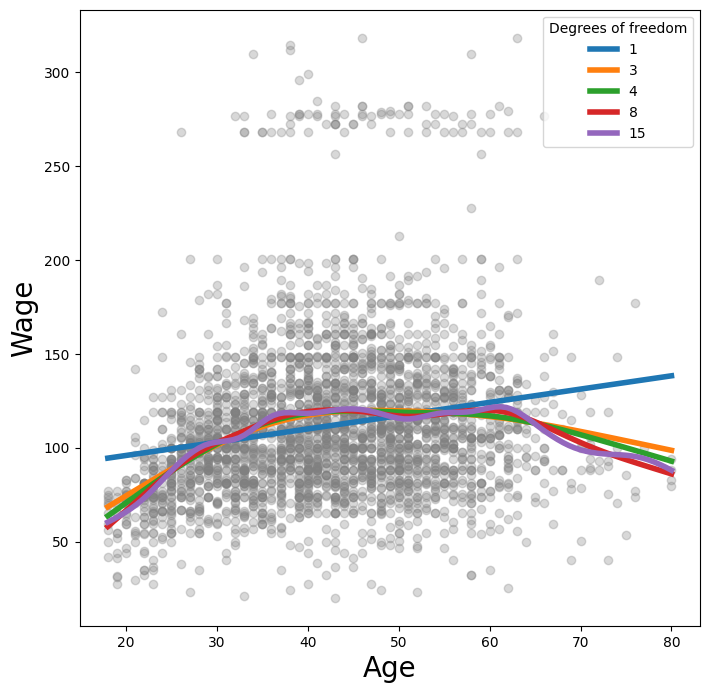

In [ ]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');


### Additive Models with Several Terms
The strength of generalized additive models lies in their ability to fit multivariate regression models with more flexibility than linear models. We demonstrate two approaches: the first in a more manual fashion using natural splines and piecewise constant functions, and the second  using the `pygam` package and smoothing splines.

We now fit a GAM by hand to predict
`wage` using natural spline functions of `year` and `age`,
treating `education` as a qualitative predictor, as in (\ref{Ch7:nsmod}).
Since this is just a big linear regression model
using an appropriate choice of basis functions, we can simply do this
using the `sm.OLS()`  function.

We will build the model matrix in a more manual fashion here, since we wish
to access the pieces separately when constructing partial dependence plots.

In [ ]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()


Here the function `NaturalSpline()` is the workhorse supporting
the `ns()` helper function.  We chose to use all columns of the
indicator matrix for the categorical variable `education`, making an intercept redundant.
Finally, we stacked the three component matrices horizontally to form the model matrix `X_bh`.

We now show how to construct partial dependence plots for each of the terms in our rudimentary GAM. We can do this by hand,
given grids for `age` and `year`.
 We simply predict with new $X$ matrices, fixing all but one of the features at a time.

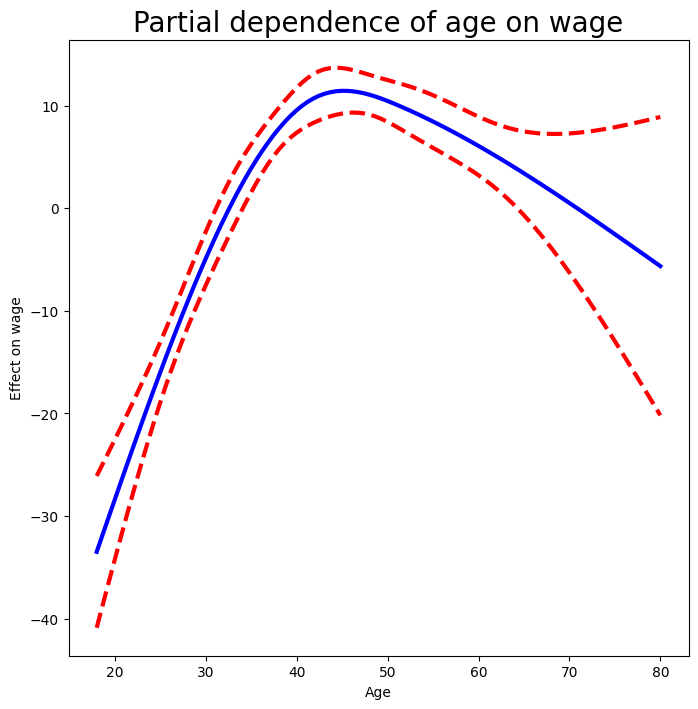

In [ ]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);


Let's explain in some detail what we did above. The idea is to create a new prediction matrix, where all but the columns belonging to `age` are constant (and set to  their training-data means). The four columns for `age` are filled in with the natural spline basis evaluated at the 100 values in `age_grid`.

* We made a grid of length 100 in `age`, and created a matrix `X_age_bh` with 100 rows and the same number of columns as `X_bh`.
* We replaced every row of this matrix with the column means of the original.
* We then replace just the first four columns representing `age` with the natural spline basis computed at the values in `age_grid`.

The remaining steps should by now be familiar.

We also look at the effect of `year` on `wage`; the process is the same.

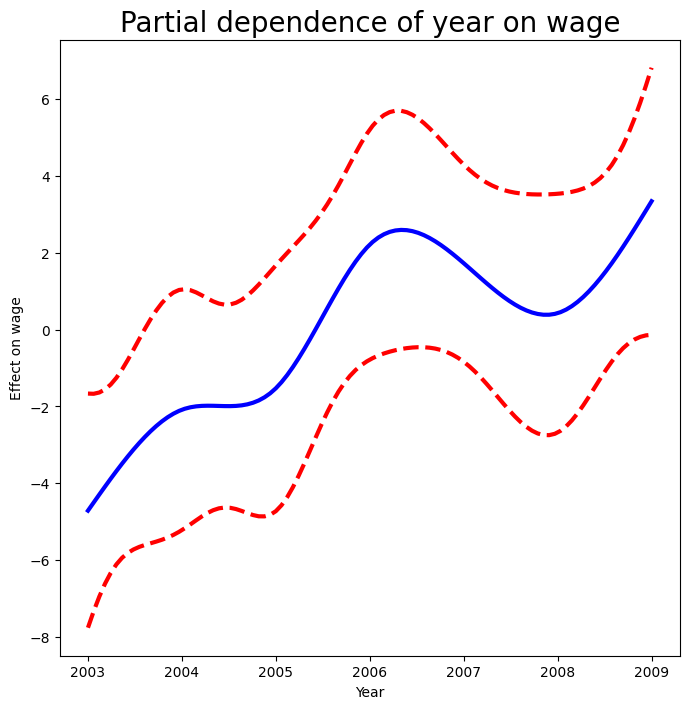

In [ ]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);


We now fit the model (\ref{Ch7:nsmod})  using smoothing splines rather
than natural splines.  All of the
terms in  (\ref{Ch7:nsmod})  are fit simultaneously, taking each other
into account to explain the response. The `pygam` package only works with matrices, so we must convert
the categorical series `education` to its array representation, which can be found
with the `cat.codes` attribute of `education`. As `year` only has 7 unique values, we
use only seven basis functions for it.

In [ ]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)


The two `s_gam()` terms result in smoothing spline fits, and use a default value for $\lambda$  (`lam=0.6`), which is somewhat arbitrary. For the categorical term `education`, specified using a `f_gam()` term,  we specify `lam=0` to avoid any shrinkage.
We produce the partial dependence plot in `age` to see the effect of these choices.

The values for the plot
are generated by the `pygam` package. We provide a `plot_gam()`
function for partial-dependence plots in `ISLP.pygam`, which makes this job easier than in our last example with natural splines.

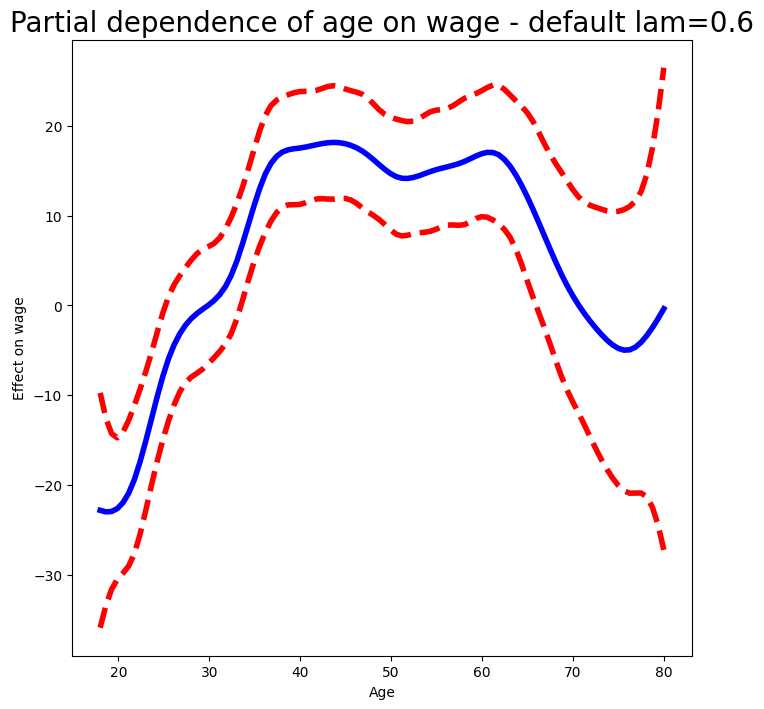

In [ ]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20);


We see that the function is somewhat wiggly. It is more natural to specify the `df` than a value for `lam`.
We refit a GAM using four degrees of freedom each for
`age` and  `year`. Recall that the addition of one below takes into account the intercept
of the smoothing spline.

In [ ]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)


Note that updating `age_term.lam` above updates it in `gam_full.terms[0]` as well! Likewise for `year_term.lam`.

Repeating the plot for `age`, we see that it is much smoother.
We also produce the plot for `year`.

Text(0.5, 1.0, 'Partial dependence of year on wage')

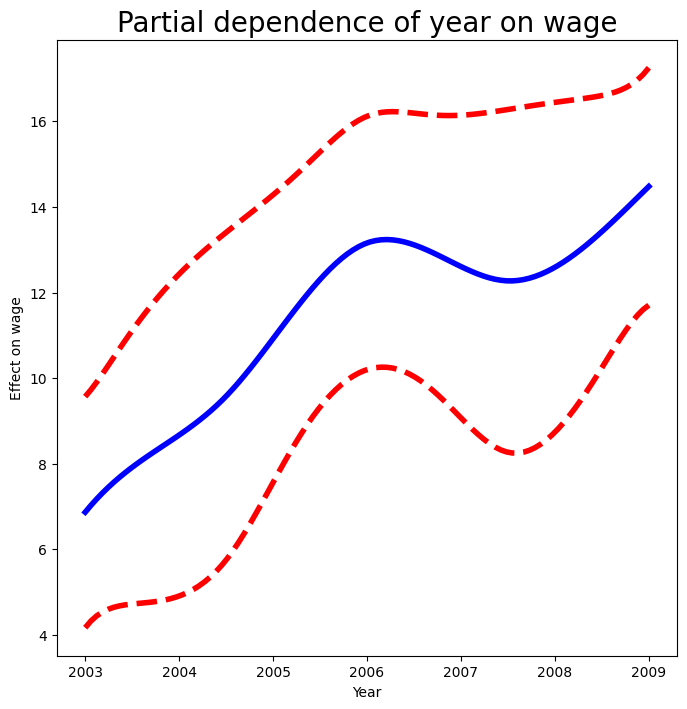

In [ ]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)


Finally we plot `education`, which is categorical. The partial dependence plot is different, and more suitable for the set of fitted constants for each level of this variable.

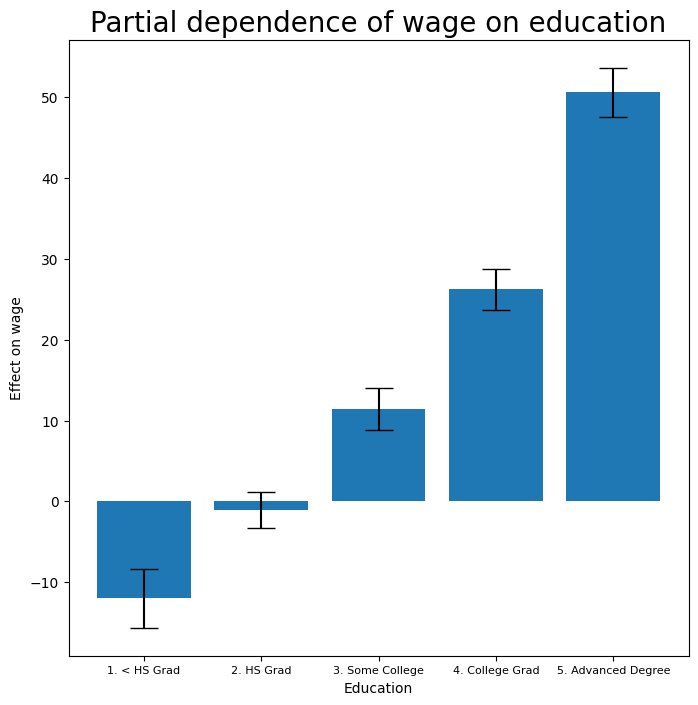

In [ ]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);


### ANOVA Tests for Additive Models
In all of our models, the function of `year` looks rather linear. We can
perform a series of ANOVA tests in order to determine which of these
three models is best: a GAM that excludes `year` ($\mathcal{M}_1$),
a GAM that uses a linear function of `year` ($\mathcal{M}_2$), or a
GAM that uses a spline function of `year` ($\mathcal{M}_3$).

In [ ]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0) +
                       f_gam(2, lam=0))
gam_linear.fit(Xgam, y)


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

Notice our use of `age_term` in the expressions above. We do this because
earlier we set the value for `lam` in this term to achieve four degrees of freedom.

To directly assess the effect of `year` we run an ANOVA on the
three models fit above.

In [ ]:
anova_gam(gam_0, gam_linear, gam_full)


,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


 We find that there is compelling evidence that a GAM with a linear
function in `year` is better than a GAM that does not include
`year` at all ($p$-value= 0.002). However, there is no
evidence that a non-linear function of `year` is needed
($p$-value=0.435).  In other words, based on the results of this
ANOVA, $\mathcal{M}_2$ is preferred.

We can repeat the same process for `age` as well. We see there is very clear evidence that
a non-linear term is required for `age`.

In [ ]:
gam_0 = LinearGAM(year_term +
                  f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
                       year_term +
                       f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


There is a (verbose) `summary()` method for the GAM fit.

In [ ]:
gam_full.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

We can make predictions from `gam` objects, just like from
`lm` objects, using the `predict()`  method for the class
`gam`.  Here we make predictions on the training set.

In [ ]:
Yhat = gam_full.predict(Xgam)


In order to fit a logistic regression GAM, we use `LogisticGAM()`
from `pygam`.

In [ ]:
gam_logit = LogisticGAM(age_term +
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

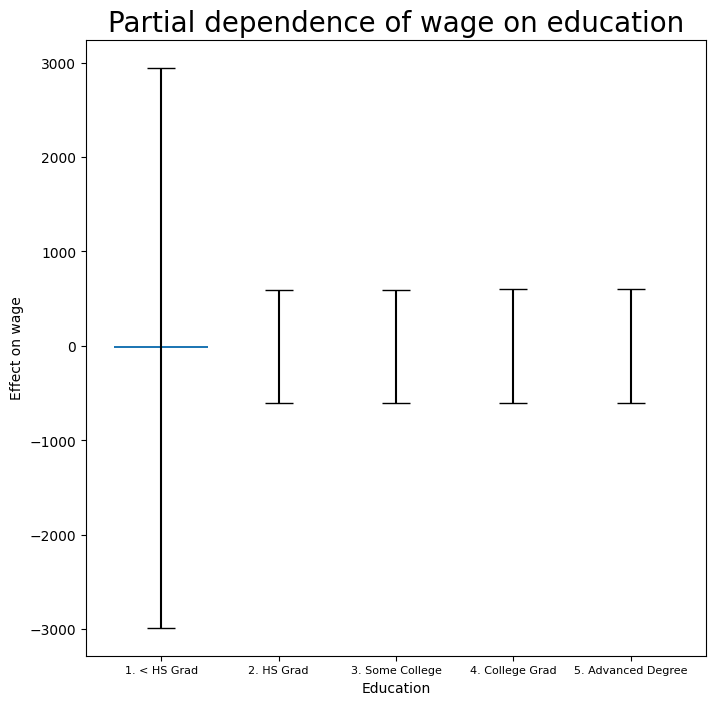

In [ ]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);


The model seems to be very flat, with especially high error bars for the first category.
Let's look at the data a bit more closely.

In [ ]:
pd.crosstab(Wage['high_earn'], Wage['education'])


education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


We see that there are no high earners in the first category of
education, meaning that the model will have a hard time fitting.  We
will fit a logistic regression GAM excluding all observations falling into this
category. This provides more sensible results.

To do so,
we could subset the model matrix, though this will not remove the
column from `Xgam`. While we can deduce which column corresponds
to this feature, for reproducibility’s sake we reform the model matrix
on this smaller subset.


In [ ]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
                         Wage_['year'],
                         Wage_['education'].cat.codes-1])
high_earn_ = Wage_['high_earn']


In the second-to-last line above, we subtract one  from the codes of the category, due to a bug in `pygam`. It just relabels
the education values and hence has no effect on the fit.

We now fit the model.

In [ ]:
gam_logit_ = LogisticGAM(age_term +
                         year_term +
                         f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

Let’s look at the effect of `education`, `year` and `age` on high earner status now that we’ve
removed those observations.

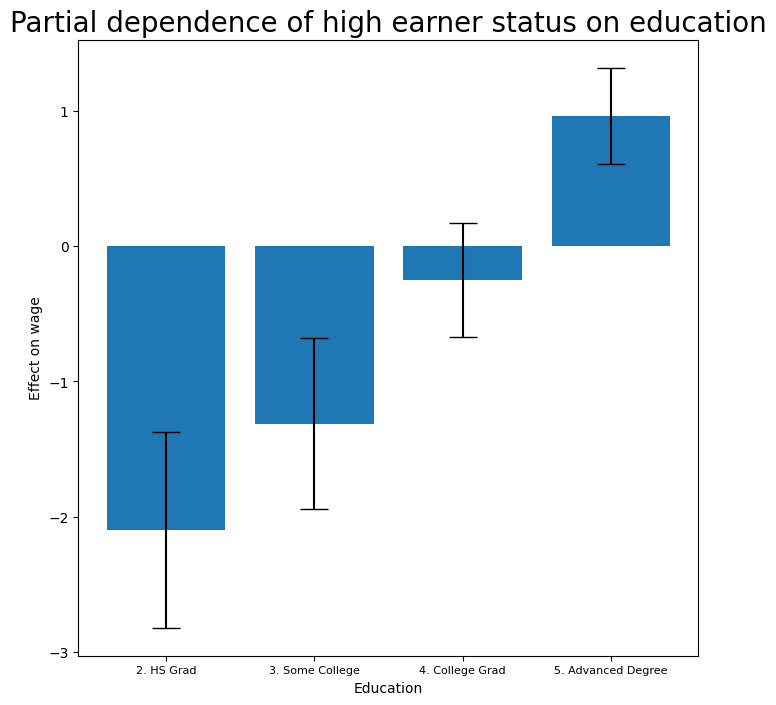

In [ ]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:],
                   fontsize=8);


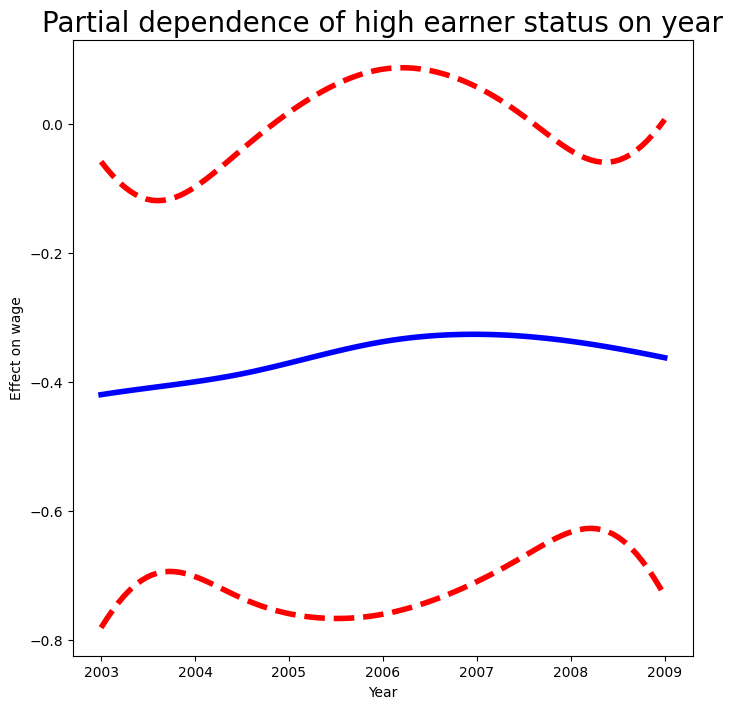

In [ ]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',
             fontsize=20);


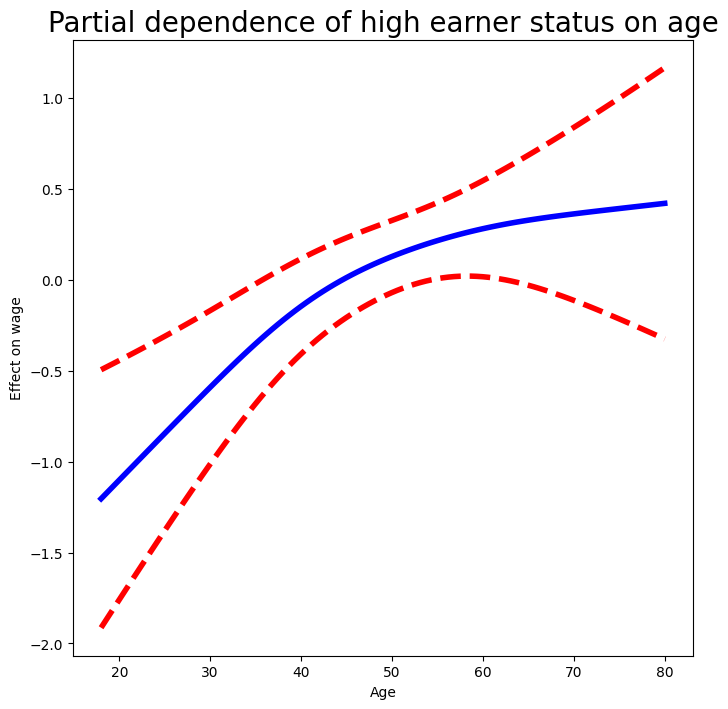

In [ ]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age', fontsize=20);


## Local Regression
We illustrate the use of local regression using  the `lowess()`
function from `sm.nonparametric`. Some implementations of
GAMs allow terms to be local regression operators; this is not the case in `pygam`.

Here we fit local linear regression models using spans of 0.2
and 0.5; that is, each neighborhood consists of 20% or 50% of
the observations. As expected, using a span of 0.5 is smoother than 0.2.

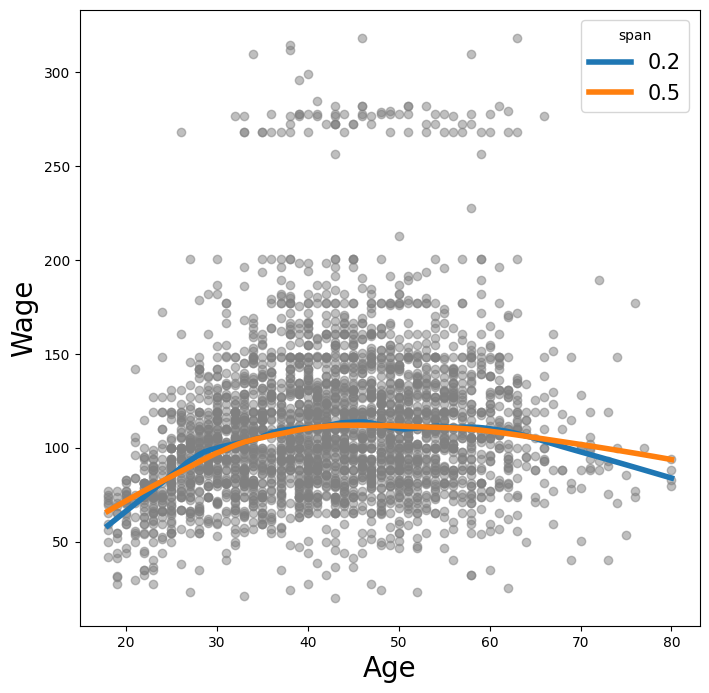

In [ ]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age,
                    frac=span,
                    xvals=age_grid)
    ax.plot(age_grid,
            fitted,
            label='{:.1f}'.format(span),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);
